In this notebook, we concatenate all the game data into 1 data frame, then train an XGBoost model for Whiff%. We'll calculate stuff+ for generic fastballs, offspeed, and breaking balls.

First, we define the file path that contains all the data, and concatenate all csv files in the selected path 

In [2]:
import os
import pandas as pd
import numpy as np
import xgboost
from docutils.nodes import header
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [3]:
csv_dir = '../../SEC Trackman Data/'
all_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('.csv')]

df_list = []

for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

all_pitches = pd.concat(df_list, ignore_index=True)

print(all_pitches.shape)
print(all_pitches.columns)

(270589, 167)
Index(['PitchNo', 'Date', 'Time', 'PAofInning', 'PitchofPA', 'Pitcher',
       'PitcherId', 'PitcherThrows', 'PitcherTeam', 'Batter',
       ...
       'ThrowTrajectoryZc1', 'ThrowTrajectoryZc2', 'PitchReleaseConfidence',
       'PitchLocationConfidence', 'PitchMovementConfidence',
       'HitLaunchConfidence', 'HitLandingConfidence',
       'CatcherThrowCatchConfidence', 'CatcherThrowReleaseConfidence',
       'CatcherThrowLocationConfidence'],
      dtype='object', length=167)


Now that all the pitches have been combined into one large data frame, we can begin to subset the data based on pitch type. We first have to find out what pitch types there are, and classify each as a fastball, off-speed, or breaking ball

In [6]:
tagged_pitch_types = all_pitches['TaggedPitchType'].unique()
print(tagged_pitch_types)

auto_pitch_types = all_pitches['AutoPitchType'].unique()
print(auto_pitch_types)

['Fastball' 'Slider' 'ChangeUp' 'Curveball' 'Cutter' 'Other' 'Undefined'
 'Sinker' 'Knuckleball' 'Splitter' 'FourSeamFastBall' 'TwoSeamFastBall'
 'OneSeamFastBall']
['Sinker' 'Four-Seam' 'Curveball' 'Changeup' 'Slider' 'Cutter' nan
 'Splitter' 'Other']


Now that we know what types of pitches there are, we can create the three desired subsets

In [4]:
fastballs = all_pitches[all_pitches['TaggedPitchType'].isin(['Fastball','Cutter','Sinker','FourSeamFastBall','TwoSeamFastBall','OneSeamFastBall'])]
off_speed = all_pitches[all_pitches['TaggedPitchType'].isin(['ChangeUp','Splitter'])]
breaking_balls = all_pitches[all_pitches['TaggedPitchType'].isin(['Slider','Curveball','Knuckleball'])]

print(fastballs.shape)
print(off_speed.shape)
print(breaking_balls.shape)

(152663, 167)
(31218, 167)
(80860, 167)


Now we have the three different data frames created, we can create a new column called 'Whiff' with a 1 if there is a swinging strike or a 0 if not.

In [5]:
fastballs['whiff'] = np.where(fastballs['PitchCall']=='StrikeSwinging',1,0)
off_speed['whiff'] = np.where(off_speed['PitchCall']=='StrikeSwinging',1,0)
breaking_balls['whiff'] = np.where(breaking_balls['PitchCall']=='StrikeSwinging',1,0)

C:\Users\charl\AppData\Local\Temp\ipykernel_10848\2223113172.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs['whiff'] = np.where(fastballs['PitchCall']=='StrikeSwinging',1,0)
C:\Users\charl\AppData\Local\Temp\ipykernel_10848\2223113172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  off_speed['whiff'] = np.where(off_speed['PitchCall']=='StrikeSwinging',1,0)
C:\Users\charl\AppData\Local\Temp\ipykernel_10848\2223113172.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Now, we can examine the columns and determine which ones we want for predictors in our model. Now that we have whether a pitch was a whiff or not, we can begin determining which variables we want as predictors

In [6]:
numeric_cols = breaking_balls.select_dtypes(include=['number']).columns
print(numeric_cols)

Index(['PitchNo', 'PAofInning', 'PitchofPA', 'PitcherId', 'BatterId', 'Inning',
       'Outs', 'Balls', 'Strikes', 'OutsOnPlay',
       ...
       'ThrowTrajectoryXc0', 'ThrowTrajectoryXc1', 'ThrowTrajectoryXc2',
       'ThrowTrajectoryYc0', 'ThrowTrajectoryYc1', 'ThrowTrajectoryYc2',
       'ThrowTrajectoryZc0', 'ThrowTrajectoryZc1', 'ThrowTrajectoryZc2',
       'whiff'],
      dtype='object', length=121)


Define Predictors

In [7]:
bb_preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

Now, we can subset each of the pitch dfs with the predictors and response

In [8]:

breaking_balls_X = breaking_balls[bb_preds]
breaking_balls_y = breaking_balls['whiff']

Train model for breaking balls

In [9]:
X_train, X_test, y_train, y_test = train_test_split(breaking_balls_X, breaking_balls_y, test_size=.33)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.19%


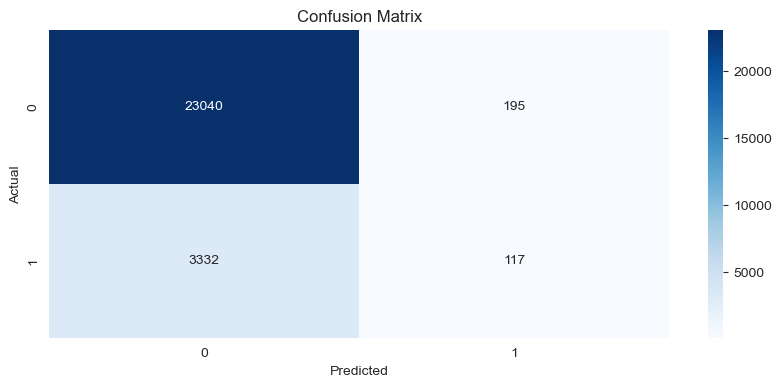

In [16]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

0 = Whiff, 1 = Non-Whiff

In [17]:
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.6243
Recall: 0.5128
F1 Score: 0.4956


In [1]:
y_pred_prob = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, predictions, multi_class='ovr')

print(f'ROC AUC: {roc_auc:.4f}')

# Plotting ROC Curve for one class (e.g., class 0)
fpr, tpr, _ = roc_curve(y_test == 0, y_pred_prob)
plt.plot(fpr, tpr, label='Class 0 ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

NameError: name 'model' is not defined

Though the model runs, it still needs to be optimized. Next step, variable selection/importance!

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

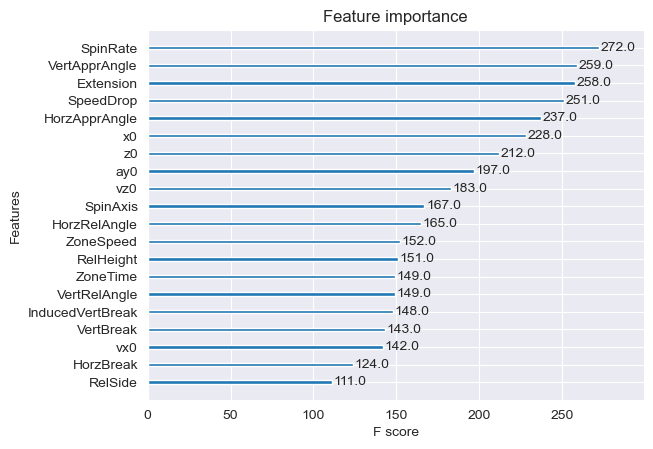

In [19]:
xgboost.plot_importance(model, max_num_features=20)

Compared to the feature importance of fastballs, Spin Rate, Vertical Approach Angle and Extension are still the 3 most important variables based on F-Score. However, it appears that Speed Drop has increased significance. This makes sense in terms of analyzing breaking balls. Spin Axis was also a climber in comparison to fastballs.

 99%|===================| 53736/54176 [02:03<00:01]        

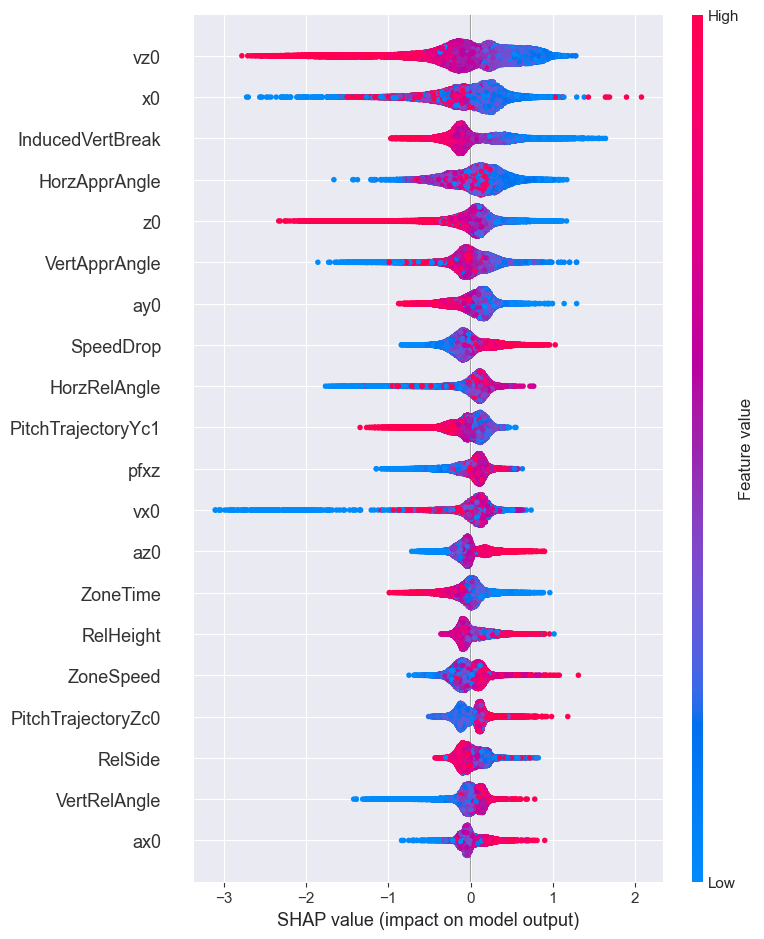

In [20]:
# Step 1: Initialize the SHAP explainer
explainer = shap.Explainer(model, X_train)

# Step 2: Calculate SHAP values for the training data
shap_values = explainer(X_train)

# Step 3: Plot a summary plot
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

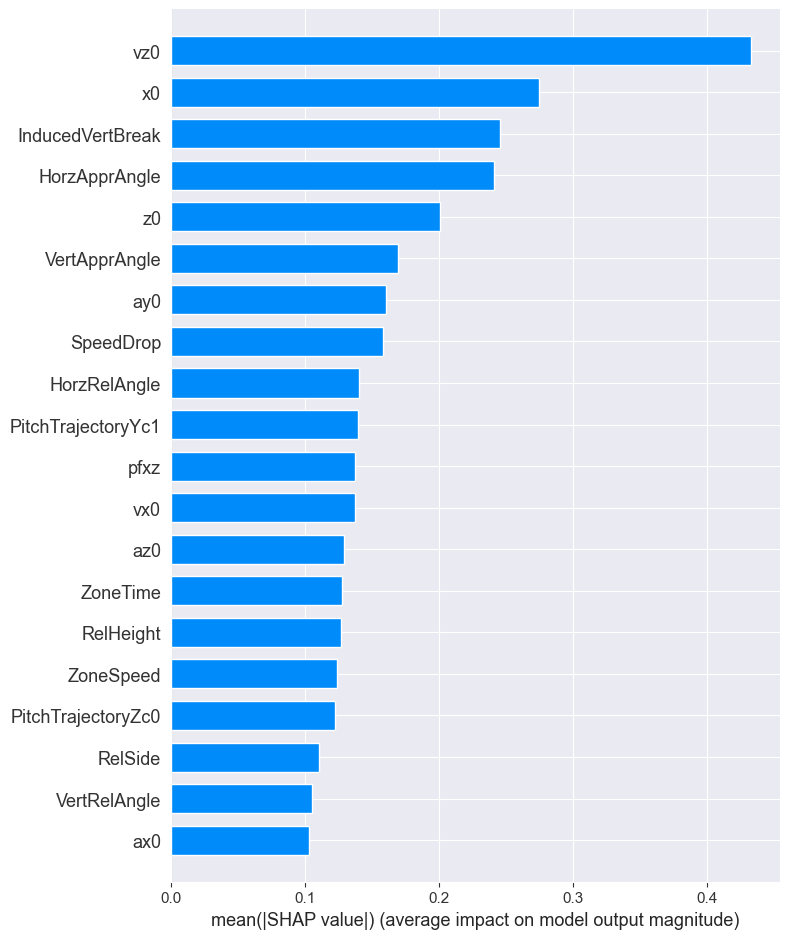

In [21]:
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, plot_type='bar')

Now for a demonstration on calculating stuff+, let's select a few pitches from the data set, calculate their whiff percentage, and divide that by the average predicted whiff percentage for all the pitches

In [10]:
all_preds = model.predict_proba(breaking_balls_X)[:,1]
mean_pred = np.mean(all_preds)

print(mean_pred)

sample = breaking_balls_X.sample(n=10)

sample_preds = model.predict_proba(sample)[:,1]

stuff = sample_preds/mean_pred

print(stuff*100)

0.13037482
[172.72607  197.78087  114.6211   124.85807  121.554924 115.228294
  32.49467  164.00748   34.202915 124.45522 ]


Each of these values represents the Stuff+ for that pitch, defined by predicted whiff% / average whiff%. This will mean a lot more if we average all the values for each pitcher 

In [11]:
# Get unique values
unique_values = breaking_balls['Pitcher'].unique()

#Print list of pitchers to choose from
print(unique_values, len(unique_values))

# Create a dictionary to store subsets
subsets = {value: breaking_balls[breaking_balls['Pitcher'] == value] for value in unique_values}

['Dettmer, Nathan' 'Tidwell, Blade' 'Menefee, Joseph' ...
 'Pingeton, Anthony' 'Causey, A.J.' "O'Brien Cameron"] 2034


In [12]:
all_preds = model.predict_proba(breaking_balls_X)[:,1]
mean_pred = np.mean(all_preds)


b_tidwell = subsets['Skenes, Paul']
b_tidwell_X = b_tidwell[bb_preds]

whiff_preds = model.predict_proba(b_tidwell_X)[:,1]

stuff = whiff_preds/mean_pred

print(f"Blade Tidwell Breaking Ball stuff+:{np.mean(stuff*100)}")

Blade Tidwell Breaking Ball stuff+:180.96255493164062


Now, this lumps in all of his fastballs. Let's see if he throws multiple types of fastballs and see how they all stack up

In [31]:
print(b_tidwell['TaggedPitchType'].unique())

['Slider']


Tidwell only throws a slider. We can see how his slider stacks up against all other breaking balls. Obviously this is not ideal (we want to compare sliders to sliders, etc.) but it will do for now

In [32]:
bt_spd_avg = np.mean(b_tidwell['RelSpeed'])
bt_spd_std = np.std(b_tidwell['RelSpeed'])

bt_hgt_avg = np.mean(b_tidwell['RelHeight'])
bt_hgt_std = np.std(b_tidwell['RelHeight'])

bt_side_avg = np.mean(b_tidwell['RelSide'])
bt_side_std = np.std(b_tidwell['RelSide'])

Now we can look at what makes his slider different from some other sliders

In [33]:
similar_sliders = breaking_balls[(breaking_balls['RelSpeed'] >= bt_spd_avg - bt_spd_std) &
                              (breaking_balls['RelSpeed'] <= bt_spd_avg + bt_spd_std) &
                              (breaking_balls['RelHeight'] >= bt_hgt_avg - bt_hgt_std) &
                              (breaking_balls['RelHeight'] <= bt_hgt_avg + bt_hgt_std) &
                              (breaking_balls['RelSide'] >= bt_side_avg - bt_side_std) &
                              (breaking_balls['RelSide'] <= bt_side_avg + bt_side_std)]

print(similar_sliders.shape)

(2716, 168)


In [34]:
similar_sliders['stuff_plus'] = (model.predict_proba(similar_sliders[bb_preds])[:,1])/(mean_pred) * 100
print(similar_sliders['stuff_plus'].head(10))


21     194.975159
29      53.323185
32     117.815102
88      56.101589
91     103.370628
120     93.991264
151     35.585484
273     58.082050
278     82.408737
283     73.407623
Name: stuff_plus, dtype: float32


C:\Users\ethan\AppData\Local\Temp\ipykernel_35968\2416631850.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_sliders['stuff_plus'] = (model.predict_proba(similar_sliders[bb_preds])[:,1])/(mean_pred) * 100


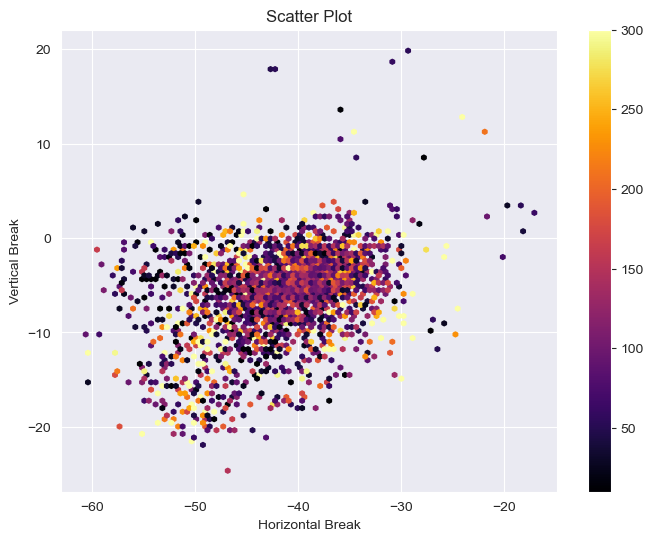

In [35]:
# Create scatter plot
plt.figure(figsize=(8, 6))
hb = plt.hexbin(x=similar_sliders['VertBreak'], y=similar_sliders['HorzBreak'], 
                C=similar_sliders['stuff_plus'], cmap='inferno', reduce_C_function=np.mean,
                vmin=10, vmax=300)

plt.colorbar(hb, label='')

# Add labels and title
plt.xlabel('Horizontal Break')
plt.ylabel("Vertical Break")
plt.title("Scatter Plot")

# Show plot
plt.show()